In [1]:
import os
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.api as sm
import numpy as np
import warnings
import shap 
import cleanlab

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from helpers import*

warnings.simplefilter("ignore")

ValueError: All ufuncs must have type `numpy.ufunc`. Received (<ufunc 'sph_legendre_p'>, <ufunc 'sph_legendre_p'>, <ufunc 'sph_legendre_p'>)

# Load processed data

In [3]:
df = pd.read_csv("data/flour-dataset-cleaned.csv").set_index('Package ID')
class_map = {'Low': 0, 'Average': 1, 'High': 2}
classes = ['Low', 'Average', 'High']

# Split data for training

We shall make sure that train - test split have the same label distribution as whole data set.

In [4]:
X_train, X_test, y_train, y_test, train_idx, test_idx = prepare_dataset(df)

print(f"Check label distrib in train set : {y_train.value_counts() / y_train.shape[0]}")
print(f"Check label distrib in test set : {y_test.value_counts() / y_test.shape[0]}")


Check label distrib in train set : Quality
1.0    0.609979
0.0    0.369642
2.0    0.020379
Name: count, dtype: float64
Check label distrib in test set : Quality
1.0    0.609551
0.0    0.370787
2.0    0.019663
Name: count, dtype: float64


In [45]:
len(y_test)

356

## Build over sampled dataset

In [4]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

  File "c:\Users\Philippine\Documents\Job search\SDSC\flour-screening\.venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\Philippine\AppData\Roaming\uv\python\cpython-3.9.21-windows-x86_64-none\lib\subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\Philippine\AppData\Roaming\uv\python\cpython-3.9.21-windows-x86_64-none\lib\subprocess.py", line 951, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Philippine\AppData\Roaming\uv\python\cpython-3.9.21-windows-x86_64-none\lib\subprocess.py", line 1436, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


# Training

## Train a Logistic regression classifier

In [5]:
model_lg = LogisticRegression(multi_class='multinomial', random_state=42 ,penalty='l2', class_weight='balanced')
model_ft = model_lg.fit(X_train, y_train)

Balanced accuracy : 0.7061164641809802
Kappa score : 0.5488726452270936
              precision    recall  f1-score   support

         Low       0.69      0.77      0.73       132
     Average       0.86      0.77      0.81       217
        High       0.31      0.57      0.40         7

    accuracy                           0.77       356
   macro avg       0.62      0.71      0.65       356
weighted avg       0.79      0.77      0.77       356



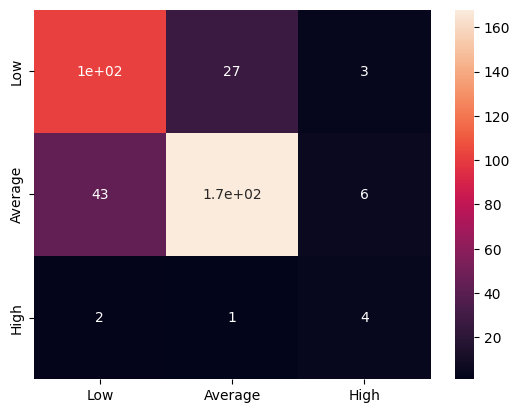

In [6]:
mis_1 = evaluate(model_ft, X_test, y_test, classes, test_idx)

## Train a MLP

In [7]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(max_iter=100, random_state=42)
mlp_fit = mlp.fit(X_train, y_train)

Balanced accuracy : 0.7056742540613508
Kappa score : 0.6968391524319992
              precision    recall  f1-score   support

         Low       0.87      0.76      0.81       132
     Average       0.85      0.93      0.89       217
        High       1.00      0.43      0.60         7

    accuracy                           0.86       356
   macro avg       0.91      0.71      0.77       356
weighted avg       0.86      0.86      0.85       356



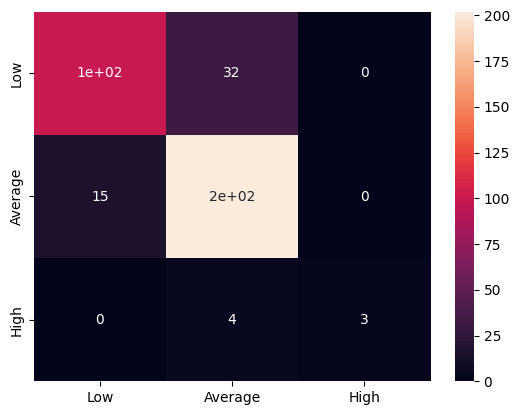

In [8]:
mis_2 = evaluate(mlp_fit, X_test, y_test, classes, test_idx)

## Train an xgboost classifier

In [29]:
sample_weights

array([0.9017744 , 0.54646697, 0.54646697, ..., 0.54646697, 0.9017744 ,
       0.54646697])

In [42]:
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.utils.class_weight import compute_sample_weight

X_train, X_test, y_train, y_test, train_idx, test_idx = prepare_dataset(df, label_dim=1)
sample_weights = y_train.map({0 : 1/0.39, 1: 1/0.59, 2: 1/0.02})
xgboost = XGBClassifier( random_state=42, eval_metric='mlogloss')

# Use MultiOutputClassifier to handle multilabel classification
#xgboost = MultiOutputClassifier(xgb, n_jobs=-1)

# Train the model
xgboost_ft = xgboost.fit(X_train, y_train, sample_weight=sample_weights)

Balanced accuracy : 0.6908602150537634
Kappa score : 0.6473443510706798
              precision    recall  f1-score   support

         Low       0.80      0.75      0.78       132
     Average       0.84      0.89      0.87       217
        High       1.00      0.43      0.60         7

    accuracy                           0.83       356
   macro avg       0.88      0.69      0.75       356
weighted avg       0.83      0.83      0.83       356



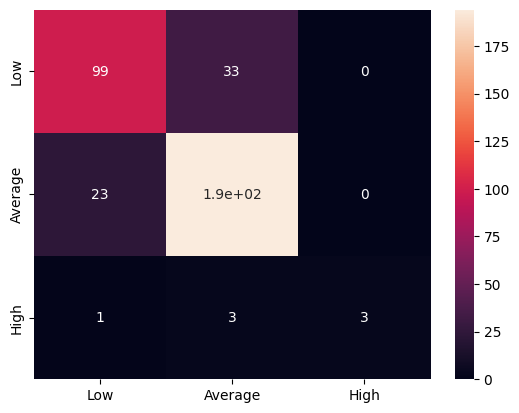

In [43]:
mis_3 = evaluate(xgboost_ft, X_test, y_test, classes, test_idx)

# Study misclassified samples

In [20]:
intersec = set(mis_1).intersection(set(mis_2)).intersection(set(mis_3))
print(len(intersec))

35


In [55]:
explainer = shap.Explainer(xgboost_ft, X_train.sample(100))  # TreeExplainer for tree-based models
shap_values = explainer(X_test)

 94%|=================== | 1003/1068 [00:13<00:00]       

In [61]:
shape_values_high_qual = shap_values[y_test.to_numpy() == 2]

In [62]:
shap.plots.waterfall(shape_values_high_qual[:,2])

ValueError: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (7, 3)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.

In [54]:
y_test[list(intersec)].value_counts()

Quality
0.0    22
1.0    10
2.0     3
Name: count, dtype: int64

# Study predictions

 90%|==================  | 965/1068 [00:11<00:01]       

Feature Importance (SHAP values):


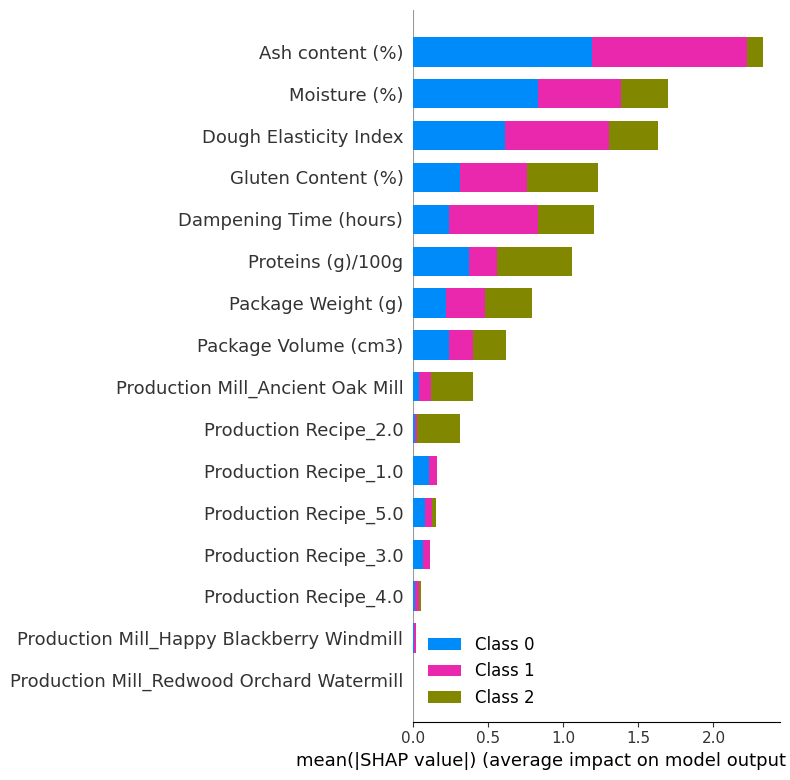

In [47]:
explainer = shap.Explainer(xgboost_ft, X_train.sample(100))  # TreeExplainer for tree-based models
shap_values = explainer(X_test)
features = df.drop('Quality', axis=1).columns


# Step 4: Visualize feature importance
print("Feature Importance (SHAP values):")
shap.summary_plot(shap_values, X_test, feature_names=features)